# A CNN to predict face attractiveness 

## 1. Global setup

We import the general modules and define the global constants that will be useful throughout this program.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
MAIN_PATH = 'input/celeba_dataset/'
DATA_PATH = MAIN_PATH + 'img_align_celeba/img_align_celeba/'
ATTRIBUTE_PATH = MAIN_PATH + 'list_attr_celeba.csv'
EXAMPLE_PIC = DATA_PATH + '000001.jpg'
TEST_PIC_PATH = './test_pic/'

## 2. Import and explore dataset

This project is based on the Celeba dataset provided on Kaggle. We have downloaded it and imported it into the root of this project.

First, let's import the dataset and see what it contains:

In [ ]:
dataset = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')
dataset.head()

Let's display the first image of our dataset to see how it looks.

In [ ]:
from keras.preprocessing.image import load_img

img1 = load_img(EXAMPLE_PIC)
plt.imshow(img1)
plt.show()

In this project, you are asked to build and train a convolutional neural network model able to detect the presence or not of **one specific human feature in face images. So, we have to select one attribute for our model. To do this, we looked at attributes and check if data are well balanced. We visualize them with bar charts.

After looking at several attributes, we've chosen to detect whether people are attractive or not. As you can see, the bar chart below is well balanced, and in addition it's funny :)

In [ ]:
import seaborn as sns

print("Attractiveness distribution over the dataset:")
plt.title('Attractiveness Distribution')
sns.countplot(y='Attractive', data=dataset)
plt.show()

## 3. Data pre-processing

Next, the dataset is split into two parts; on the one hand the data that will be used to train the models and on the other hand the data that will be used to measure performance.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 0)

Let's check that our dataset has been successfully split

In [ ]:
print("Train shape: ", train_set.shape)
print("Test shape: ", test_set.shape)

Now we will create 2 directories. One directory for the `training_set` and a second one for the `testing_set`. Each directories will contain 2 subdirectories. Those subdirectories correspond to the absence or presence of the attribute. In our case, in each directory, we will have a subdirectory `attractive` and a second `not_attractive`. 

In [ ]:
import os

# Create our 2 directories
os.makedirs("input/attractiveness/train_set")
os.makedirs("input/attractiveness/test_set")

# Create subdirectories in each one
os.makedirs("input/attractiveness/test_set/not_attractive")
os.makedirs("input/attractiveness/test_set/attractive")
os.makedirs("input/attractiveness/train_set/attractive")
os.makedirs("input/attractiveness/train_set/not_attractive")

Now, we split our `train_set` into 2 parts. One part contains only the attractive people. And a second part containing not_attractive people.

In [ ]:

train_set_not_attractive = train_set.query('Attractive == -1')
train_set_attractive = train_set.query('Attractive == +1')

All that remains is to add them to the corresponding subdirectories.

In [ ]:
import shutil

for img in train_set_not_attractive.index.values:
  shutil.copy(DATA_PATH + img, "input/attractiveness/train_set/not_attractive")
for img in train_set_attractive.index.values:
  shutil.copy(DATA_PATH + img, "input/attractiveness/train_set/attractive")

We can do the exact same thing for our `test_set`.

In [ ]:
test_set_not_attractive = test_set.query('Attractive == -1')
test_set_attractive = test_set.query('Attractive == +1')

for img in test_set_not_attractive.index.values:
  shutil.copy(DATA_PATH + img, "input/attractiveness/test_set/not_attractive")
for img in test_set_attractive.index.values:
  shutil.copy(DATA_PATH + img, "input/attractiveness/test_set/attractive")

## 4. Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

## 5. Building CNN

In [ ]:
TARGET_SIZE = (64, 64)
BATCH_SIZE = 128

Create the training and testing sets for the CNN classifier.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'input/attractiveness/train_set',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    'input/attractiveness/test_set',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

Build our CNN model, with 2 convolutions layers.

In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the CNN
classifier = Sequential()

# Convolution layer 1
classifier.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer 2
classifier.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units= 128, activation='relu'))
classifier.add(Dense(units= 1, activation='sigmoid'))

Compile and get the summary of our model.

In [ ]:
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

In [ ]:
history = classifier.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

Save the classifier at the root of our repository to use it later (without the need to re-compile the classifier).

In [ ]:
classifier.save('./exported_model/attractiveness_model.h5')

## 6. Evaluate the model

Load our already trained model.

In [3]:
from keras.models import load_model

classifier= load_model('./exported_model/attractiveness_model.h5')

To see if the model is still learning, we display the loss as a function of the number of epochs. 

In [ ]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Our model obtains an accuracy of 80% and an loss of 46%. This poor metrics can be explained by the attribute we've chosen. Attractiveness is subjective. So its prediction is much harder than predicting a gender or if someone is smiling.

In [ ]:
results = classifier.evaluate(validation_generator, verbose=0)
results

We can summarize the performance of our classification model using a confusion matrix.

In [ ]:
predictions = classifier.predict(validation_generator)
predictions = (predictions > 0.5)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(validation_generator.classes, predictions)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

## 7. Predict a single image

Finally we're going to use our model to predict attractiveness on a single picture.

In [4]:
from keras_preprocessing import image

def classify(imagePath):
  test_image = image.load_img(imagePath, target_size = (64, 64))
  test_image = image.img_to_array(test_image).astype('float32') / 255 
  test_image = np.expand_dims(test_image, axis = 0) # add an extra dimension to fake batch

  result = classifier.predict(test_image)
  if result[0][0] >= 0.5:
      prediction = 'attractive'
      probability = result[0][0]
  else:
      prediction = 'not attractive'
      probability = 1 - result[0][0]
  print("This person is " + prediction + " (" + str(probability * 100) + "%).")

In [5]:
from keras.preprocessing.image import load_img

def showImage(imagePath):
  img = load_img(imagePath)
  plt.imshow(img)
  plt.show()

This person is attractive (98.79876375198364%).


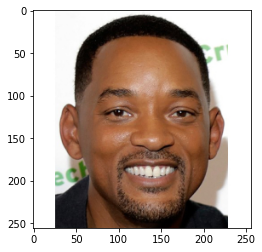

In [11]:
imageToClassify = TEST_PIC_PATH + "2.jpg" # Can test from 0 to 3
classify(imageToClassify)
showImage(imageToClassify)

The model does not perform well at all. When we test images from the dataset the output is different from the expected result.

## Conclusion

We get very bad results with this model. The loss is very important, that's why the results obtained are not up to our expectations.

This lack of performance is explained by the subjectivity of the attractiveness attribute. To demonstrate this, we've created a second, identical model that detects the smile. You can visualize it in the smiling.ipynb file.